# Machine Learning for Networking - Group Project 5 - DDoS attacks detection and characterization - Section 3 & 4
# Preliminaries operations

## Import needed libraries

In [1]:
#Import needed libraries
! pip3 install shap

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from joblib import Parallel, delayed
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score, rand_score
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import shap



Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


## Data preparation & standardization

In [2]:
columns_to_remove = ['Active Mean', 'Active Std', 'Average Packet Size', 'Avg Bwd Segment Size', 'Avg Fwd Segment Size',
                     'Bwd IAT Max', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd Packet Length Mean', 'Bwd Packet Length Std',
                     'Flow Duration', 'Flow IAT Max', 'Flow IAT Mean', 'Flow IAT Min', 'Flow IAT Std', 'Flow Packets/s',
                     'Fwd Header Length', 'Fwd IAT Max', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Total',
                     'Fwd PSH Flags', 'Fwd Packet Length Mean', 'Fwd Packet Length Min', 'Idle Max', 'Idle Mean',
                     'Min Packet Length', 'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance',
                     'Protocol', 'Subflow Bwd Bytes', 'Subflow Bwd Packets', 'Subflow Fwd Bytes', 'Subflow Fwd Packets',
                     'Total Backward Packets', 'Total Length of Bwd Packets', 'Total Length of Fwd Packets']

ddos_data = pd.read_csv("ddos_dataset.csv", sep=",")
ddos_data.rename(columns=lambda x: x.strip(), inplace=True)
ddos_data['SimillarHTTP'] = ddos_data['SimillarHTTP'].apply(lambda x: str(x) if x == 0 else x)
ddos_data['SimillarHTTP'] = ddos_data['SimillarHTTP'].str.strip().fillna(0, inplace=True)
ddos_data = ddos_data.drop(columns=columns_to_remove, errors='ignore')

Columns (85) have mixed types.Specify dtype option on import or set low_memory=False.


In [3]:
#standardize
# Get X and y
ddos_data.drop(columns=["Unnamed: 0", "Destination IP", "Source IP", "Timestamp", "SimillarHTTP"], axis=1, inplace=True)
ddos_data_original = ddos_data.copy()
ddos_data = ddos_data.set_index('Flow ID')
X = ddos_data.drop(columns=['label']).to_numpy()
y = ddos_data[['label']].values

# Scale Data
scaler = StandardScaler()
X_s = scaler.fit_transform(X)

#PCA
pca = PCA(n_components=9, random_state=15)
X_s = pca.fit_transform(X_s)


# Section 3

The aim of this section is to find the best clustering algorithm with the best $k$.

## 1 Unsupervised Learning: K-means attempt
First of all, we define a function to perform k-means clustering and store metrics


In [4]:
def perform_kmeans_clustering(n_clusters, X_s, y):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cl_labels = kmeans.fit_predict(X_s)
    silhouette = silhouette_score(X_s, cl_labels)
    ri = rand_score(np.ravel(y), cl_labels)
    ari = adjusted_rand_score(np.ravel(y), cl_labels)
    inertia = kmeans.inertia_
    return n_clusters, silhouette, ri, ari, inertia, cl_labels

In [5]:
%%time

# Arrays init
n_cluster_list_kmeans = []
shs_list_kmeans = []
ri_list_kmeans = []
ari_list_kmeans = []
inertia_list_kmeans = []

# Define a range of n_clusters for the initial broader search
initial_range = range(3, 16, 3)

# Use Parallel and delayed to parallelize the loop
results_kmeans = Parallel(n_jobs=-1)(
    delayed(perform_kmeans_clustering)(n_clusters, X_s, y) for n_clusters in initial_range)

# Extract the results into separate lists
n_cluster_list_kmeans, shs_list_kmeans, ri_list_kmeans, ari_list_kmeans, inertia_list_kmeans, tmp_kmeans = zip(
    *results_kmeans)

# Get n_clusters leading to the highest silhouette
best_sh_kmeans = np.max(shs_list_kmeans)
best_n_kmeans = n_cluster_list_kmeans[np.argmax(shs_list_kmeans)]
print("Best initial k: ", best_n_kmeans, " with corresponding silhouette: ", best_sh_kmeans)

# Refine search around the best k found
refined_n_cluster_list_kmeans = []
refined_shs_list_kmeans = []
refined_ri_list_kmeans = []
refined_ari_list_kmeans = []
refined_inertia_list_kmeans = []

# Define the refined range around the best k
refined_range = range(max(3, best_n_kmeans - 2), min(16, best_n_kmeans + 3))

# Use Parallel and delayed to parallelize the loop for the refined search
results_refined_kmeans = Parallel(n_jobs=-1)(
    delayed(perform_kmeans_clustering)(n_clusters, X_s, y) for n_clusters in refined_range)

# Extract the results into separate lists
refined_n_cluster_list_kmeans, refined_shs_list_kmeans, refined_ri_list_kmeans, refined_ari_list_kmeans, refined_inertia_list_kmeans, refined_cl_labels_list_kmeans = zip(
    *results_refined_kmeans)

# Get the best refined k
best_refined_sh_kmeans = np.max(refined_shs_list_kmeans)
best_refined_n_kmeans = refined_n_cluster_list_kmeans[np.argmax(refined_shs_list_kmeans)]
best_refined_kmeans = np.array([best_refined_sh_kmeans, best_refined_n_kmeans])
print("Best refined k: ", best_refined_n_kmeans, " with corresponding silhouette: ", best_refined_sh_kmeans)
# Best refined k:  14  with corresponding silhouette:  0.5376187674752735

Best initial k:  15  with corresponding silhouette:  0.49511533967765703
Best refined k:  14  with corresponding silhouette:  0.5376187674752735
CPU times: user 121 ms, sys: 331 ms, total: 453 ms
Wall time: 3min 52s


## 2 Unsupervised Learning: GMM attempt

First of all, we define a function to perform GMM clustering and store metrics


In [6]:
def perform_gmm_clustering(n_clusters, X_s, y, init_params):
    gmm = GaussianMixture(n_components=n_clusters, init_params=init_params, random_state=42)
    cl_labels = gmm.fit_predict(X_s)
    silhouette = silhouette_score(X_s, cl_labels)
    ri = rand_score(np.ravel(y), cl_labels)
    ari = adjusted_rand_score(np.ravel(y), cl_labels)
    log_likelihood = gmm.score(X_s)
    return n_clusters, silhouette, ri, ari, log_likelihood

### 2.1 First case: init_params='kmeans'

In [7]:
%%time
#In this case use as hyper-parameter init_params = kmeans

# Arrays init
n_cluster_list_gmm_kmeans = []
shs_list_gmm_kmeans = []
log_l_list_gmm_kmeans = []
ri_list_gmm_kmeans = []
ari_list_gmm_kmeans = []

# Use Parallel and delayed to parallelize the loop
results_gmm_kmeans = Parallel(n_jobs=-1)(
    delayed(perform_gmm_clustering)(n_clusters, X_s, y, 'kmeans') for n_clusters in range(3, 8))

# Extract the results into separate lists
n_cluster_list_gmm_kmeans, shs_list_gmm_kmeans, ri_list_gmm_kmeans, ari_list_gmm_kmeans, log_l_list_gmm_kmeans = zip(
    *results_gmm_kmeans)

# Get n_clusters leading to the highest silhouette
best_sh_gmm_kmeans = np.max(shs_list_gmm_kmeans)
best_n_gmm_kmeans = n_cluster_list_gmm_kmeans[np.argmax(shs_list_gmm_kmeans)]
best_gmm_kmeans = np.array([best_sh_gmm_kmeans, best_n_gmm_kmeans])
print("best k: ", best_n_gmm_kmeans, " with corresponding silhouette: ", best_sh_gmm_kmeans)
# best k:  6  with corresponding silhouette:  0.3984150665607399

best k:  6  with corresponding silhouette:  0.3984150665607399
CPU times: user 30.6 ms, sys: 13.9 ms, total: 44.5 ms
Wall time: 1min


#### Plots of Silhouette, Log-Likihood score and ARI

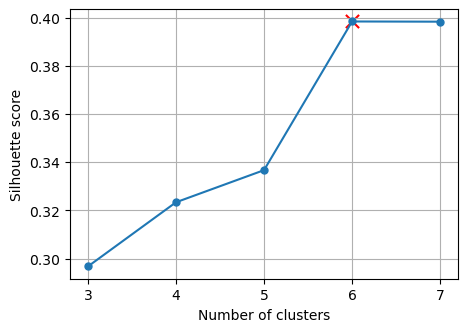

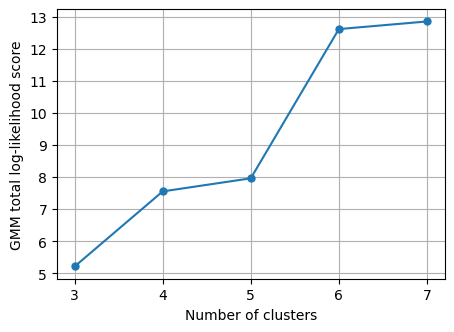

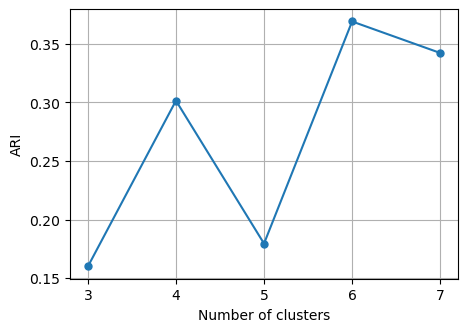

In [8]:
# Plot
plt.figure(figsize=(5, 3.5))
plt.plot(n_cluster_list_gmm_kmeans, shs_list_gmm_kmeans, marker='o', markersize=5)
plt.scatter(best_n_gmm_kmeans, best_sh_gmm_kmeans, color='r', marker='x', s=90)
plt.grid()
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.xticks(np.arange(min(n_cluster_list_gmm_kmeans), max(n_cluster_list_gmm_kmeans)+1, 1.0))
plt.show()

# Plot GMM total log-likelihood score
plt.figure(figsize=(5, 3.5))
plt.plot(n_cluster_list_gmm_kmeans, log_l_list_gmm_kmeans, marker='o', markersize=5)
plt.grid()
plt.xlabel('Number of clusters')
plt.ylabel('GMM total log-likelihood score')
plt.xticks(np.arange(min(n_cluster_list_gmm_kmeans), max(n_cluster_list_gmm_kmeans)+1, 1.0))
plt.show()

# Plot ARI
plt.figure(figsize=(5, 3.5))
plt.plot(n_cluster_list_gmm_kmeans, ari_list_gmm_kmeans, marker='o', markersize=5)
plt.grid()
plt.xlabel('Number of clusters')
plt.ylabel('ARI')
plt.xticks(np.arange(min(n_cluster_list_gmm_kmeans), max(n_cluster_list_gmm_kmeans)+1, 1.0))
plt.show()

### 2.2 Second case: init_params = random

In [9]:
%%time

#GaussianMixture
#In this case use as hyper-parameter init_params = random

#We compute the different scores for each iteration

#print(X_s)
#print(y)

# Arrays init
n_cluster_list_gmm_random = []
shs_list_gmm_random = []
ri_list_gmm_random = []
ari_list_gmm_random = []
log_l_list_gmm_random = []

# Define the range for initial search
initial_search_range = range(3, 16, 3)  # Larger step size

# Use Parallel and delayed to parallelize the initial search
results_gmm_random = Parallel(n_jobs=-1)(
    delayed(perform_gmm_clustering)(n_clusters, X_s, y, 'random') for n_clusters in initial_search_range)

n_cluster_list_gmm_random, shs_list_gmm_random, ri_list_gmm_random, ari_list_gmm_random, log_l_list_gmm_random = zip(
    *results_gmm_random)

# Find the best initial k
best_sh_gmm_random = np.max(shs_list_gmm_random)
best_n_gmm_random = n_cluster_list_gmm_random[np.argmax(shs_list_gmm_random)]

print("Best initial k: ", best_n_gmm_random, " with corresponding silhouette: ", best_sh_gmm_random)
# Best refined k:  3  with corresponding silhouette:  0.44878078445247965

# Refine search around the best k found
refined_n_cluster_list_gmm_random = []
refined_shs_list_gmm_random = []
refined_ri_list_gmm_random = []
refined_ari_list_gmm_random = []
refined_log_l_list_gmm_random = []

# Define the refined range
refined_range = range(max(3, best_n_gmm_random - 2), min(16, best_n_gmm_random + 3))

# Use Parallel and delayed to parallelize the loop for the refined search
results_refined_gmm_random = Parallel(n_jobs=-1)(
    delayed(perform_gmm_clustering)(n_clusters, X_s, y, 'random') for n_clusters in refined_range)

refined_n_cluster_list_gmm_random, refined_shs_list_gmm_random, refined_ri_list_gmm_random, refined_ari_list_gmm_random, refined_log_l_list_gmm_random = zip(
    *results_refined_gmm_random)

# Find the best refined k
best_refined_sh_gmm_random = np.max(refined_shs_list_gmm_random)
best_refined_n_gmm_random = refined_n_cluster_list_gmm_random[np.argmax(refined_shs_list_gmm_random)]
best_refined_gmm_random = np.array([best_refined_sh_gmm_random, best_refined_n_gmm_random])
print("Best refined k: ", best_refined_n_gmm_random, " with corresponding silhouette: ", best_refined_sh_gmm_random)
# Best refined k:  5  with corresponding silhouette:  0.4102666682711448

Best initial k:  3  with corresponding silhouette:  0.3603249611170074
Best refined k:  5  with corresponding silhouette:  0.4102666682711448
CPU times: user 103 ms, sys: 57.3 ms, total: 160 ms
Wall time: 2min 3s


#### Plots of Silhouette, Log-Likihood score and ARI


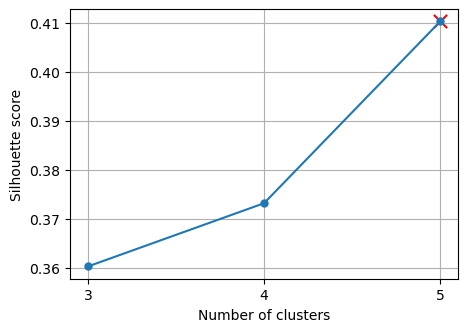

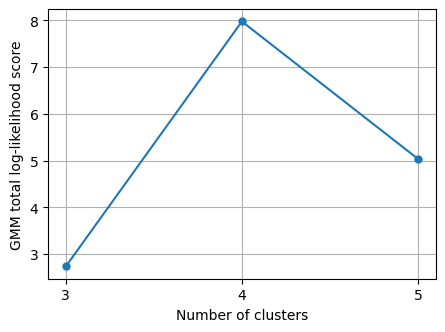

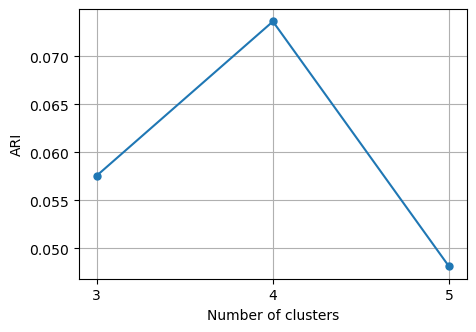

In [10]:
# Plot
plt.figure(figsize=(5, 3.5))
plt.plot(refined_n_cluster_list_gmm_random, refined_shs_list_gmm_random, marker='o', markersize=5)
plt.scatter(best_refined_n_gmm_random, best_refined_sh_gmm_random, color='r', marker='x', s=90)
plt.grid()
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.xticks(np.arange(min(refined_n_cluster_list_gmm_random), max(refined_n_cluster_list_gmm_random)+1, 1.0))
plt.show()

# Plot GMM total log-likelihood score
plt.figure(figsize=(5, 3.5))
plt.plot(refined_n_cluster_list_gmm_random, refined_log_l_list_gmm_random, marker='o', markersize=5)
plt.grid()
plt.xlabel('Number of clusters')
plt.ylabel('GMM total log-likelihood score')
plt.xticks(np.arange(min(refined_n_cluster_list_gmm_random), max(refined_n_cluster_list_gmm_random)+1, 1.0))
plt.show()

# Plot ARI
plt.figure(figsize=(5, 3.5))
plt.plot(refined_n_cluster_list_gmm_random, refined_ari_list_gmm_random, marker='o', markersize=5)
plt.grid()
plt.xlabel('Number of clusters')
plt.ylabel('ARI')
plt.xticks(np.arange(min(refined_n_cluster_list_gmm_random), max(refined_n_cluster_list_gmm_random)+1, 1.0))
plt.show()


In [11]:
%%time

# Plot ECDF per il numero di flussi per cluster
#plt.figure(figsize=(8, 5))
#sns.ecdfplot(data=cluster_df, x='NumFlows', hue='Cluster',palette='coolwarm')
#plt.title('ECDF of Number of Flows per Cluster')
#plt.xlabel('Number of Flows')
#plt.ylabel('ECDF')
#plt.show()

CPU times: user 7 µs, sys: 6 µs, total: 13 µs
Wall time: 9.54 µs


## Conclusions

In this section, we decide which is the best method of clustering, and with which k.

In [12]:
# Comparing the silhouette scores
scores = {
    "KMeans (Refined)": best_refined_kmeans[0],
    "GMM (KMeans Init)": best_gmm_kmeans[0],
    "GMM (Random Init)": best_refined_gmm_random[0]
}

# Find the algorithm with the highest score
best_algorithm = max(scores, key=scores.get)
best_score = scores[best_algorithm]

# Output the best algorithm and its score
print(f"The best clustering algorithm is {best_algorithm} with a silhouette score of {best_score}.")

# If needed, output the corresponding number of clusters
if best_algorithm == "KMeans (Refined)":
    best_n = best_refined_kmeans[1]
elif best_algorithm == "GMM (KMeans Init)":
    best_n = best_gmm_kmeans[1]
else:
    best_n = best_refined_gmm_random[1]

best_n = int(best_n)
print(f"The optimal number of clusters for {best_algorithm} is {best_n}.")

The best clustering algorithm is KMeans (Refined) with a silhouette score of 0.5376187674752735.
The optimal number of clusters for KMeans (Refined) is 14.


# Section 4
## 4.1  Do clusters reflect the GT labels ?

We use the data and the results of the k-means attempt

In [13]:
%%time

#best_n = 14 This variable could be used as hard-coded if we don't want to execute all the notebook.

model = KMeans(n_clusters=best_n, random_state=42)
cluster_labels = model.fit_predict(X_s)

print(cluster_labels)

# Calculate clustering metrics
silhouette = silhouette_score(X_s, cluster_labels)
ari = adjusted_rand_score(np.ravel(y), cluster_labels)

print(f"Silhouette Score: {silhouette}")
print(f"Adjusted Rand Index: {ari}")

[7 3 7 ... 3 3 3]
Silhouette Score: 0.5376187674752735
Adjusted Rand Index: 0.3472982159289136
CPU times: user 2min 8s, sys: 6min 1s, total: 8min 10s
Wall time: 1min 33s


In [14]:
# Find the index of best_refined_n in refined_n_cluster_list

best_refined_index = refined_n_cluster_list_kmeans.index(best_refined_n_kmeans)

# Use this index to get the corresponding cluster labels
best_refined_cl_labels = refined_cl_labels_list_kmeans[best_refined_index]

# best_refined_cl_labels now contains the cluster labels for the best refined clustering
ddos_tmp = ddos_data_original.copy()
ddos_tmp['assigned_cluster'] = best_refined_cl_labels

# Group by 'label' and count unique clusters for each label
unique_clusters_per_label = ddos_tmp.groupby('label')['assigned_cluster'].nunique()

# Create a new DataFrame from the result
label_cluster_count_df = unique_clusters_per_label.reset_index()
label_cluster_count_df.columns = ['Label', 'Unique_Clusters_Count']

# 'label_cluster_count_df' now contains each label with the count of unique clusters associated with it
print(label_cluster_count_df)

           Label  Unique_Clusters_Count
0         benign                     13
1       ddos_dns                     11
2      ddos_ldap                      6
3     ddos_mssql                      5
4   ddos_netbios                      4
5       ddos_ntp                      6
6      ddos_snmp                      1
7      ddos_ssdp                      6
8       ddos_syn                      2
9      ddos_tftp                      5
10      ddos_udp                      3
11  ddos_udp_lag                      1


## 4.1  ECDF of number of clusters assigned to each class

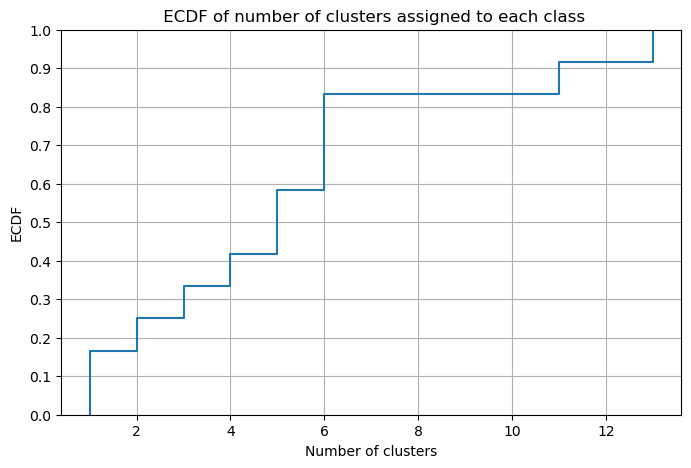

In [15]:
plt.figure(figsize=(8, 5))
sns.ecdfplot(data=label_cluster_count_df, x='Unique_Clusters_Count')
plt.title(' ECDF of number of clusters assigned to each class')
plt.xlabel('Number of clusters')
plt.ylabel('ECDF')
plt.yticks(np.arange(0, 1.1, 0.1))  # This sets y-ticks at intervals of 0.1
plt.grid(True)
plt.show()

In [16]:
# Group by cluster label
grouped_by_cluster = label_cluster_count_df.groupby('Unique_Clusters_Count')

# Initialize a dictionary to hold the purity status of each cluster
cluster_purity = {}

# Check each cluster
for cluster_label, group in grouped_by_cluster:
    unique_labels = group['Label'].unique()
    cluster_purity[cluster_label] = len(unique_labels) == 1

# Print the purity status of each cluster
for cluster_label, is_pure in cluster_purity.items():
    print(f"Cluster {cluster_label} is {'pure' if is_pure else 'not pure'}")

Cluster 1 is not pure
Cluster 2 is pure
Cluster 3 is pure
Cluster 4 is pure
Cluster 5 is not pure
Cluster 6 is not pure
Cluster 11 is pure
Cluster 13 is pure


## 4.1  What is ECDF of number of clusters assigned to each class?

In [17]:
%%time


# Analizza il numero di flussi per cluster
cluster_df = pd.DataFrame({'Cluster': cluster_labels, 'NumFlows': ddos_data.index}).reset_index()

CPU times: user 6.58 ms, sys: 0 ns, total: 6.58 ms
Wall time: 6.06 ms


In [18]:
# Group by cluster label
grouped_by_cluster = label_cluster_count_df.groupby('Unique_Clusters_Count')

# Initialize a dictionary to hold the purity status of each cluster
cluster_purity = {}

# Check each cluster
for cluster_label, group in grouped_by_cluster:
    unique_labels = group['Label'].unique()
    cluster_purity[cluster_label] = len(unique_labels) == 1

# Print the purity status of each cluster
for cluster_label, is_pure in cluster_purity.items():
    print(f"Cluster {cluster_label} is {'pure' if is_pure else 'not pure'}")

Cluster 1 is not pure
Cluster 2 is pure
Cluster 3 is pure
Cluster 4 is pure
Cluster 5 is not pure
Cluster 6 is not pure
Cluster 11 is pure
Cluster 13 is pure


## 4.1  Is there benign traffic with similar characteristics to malicious one?

This analysis can reveal patterns in the data, such as which clusters predominantly contain benign instances or specific types of DDoS attacks.

In [19]:
# Create a DataFrame combining cluster labels and actual data labels
y_ = y.ravel()
data = {'Cluster_Labels': cluster_labels, 'Real_Labels': y_}
df_ = pd.DataFrame(data)

# Function to count labels within each cluster
def count_labels(cluster_group):
    benign_count = cluster_group[cluster_group == 'benign'].count()
    ddos_counts = cluster_group[cluster_group.str.startswith('ddos_')].value_counts()
    return benign_count, ddos_counts

# Apply the function to each cluster group
cluster_info = df_.groupby('Cluster_Labels')['Real_Labels'].apply(count_labels)

# Display the results
for cluster, (benign_count, ddos_counts) in cluster_info.items():
    print(f"Cluster {cluster}:")
    print("DDoS list:")

    # Print each ddos_count with its label
    tot_count = 0
    for label, count in ddos_counts.items():
        tot_count+=count
        print(f"-{label}: {count}")
    print(f"---Malign Ddos total count: {tot_count}")
    print(f"---Benign Count: {benign_count}")
    print("\n")


Cluster 0:
DDoS list:
-ddos_tftp: 5192
-ddos_syn: 3167
-ddos_ntp: 76
-ddos_dns: 15
---Malign Ddos total count: 8450
---Benign Count: 52


Cluster 1:
DDoS list:
-ddos_mssql: 5728
-ddos_ssdp: 5573
-ddos_ldap: 5421
-ddos_dns: 585
-ddos_netbios: 412
-ddos_udp: 2
---Malign Ddos total count: 17721
---Benign Count: 1


Cluster 2:
DDoS list:
-ddos_ntp: 607
-ddos_dns: 81
-ddos_ssdp: 2
-ddos_tftp: 2
-ddos_ldap: 1
---Malign Ddos total count: 693
---Benign Count: 1632


Cluster 3:
DDoS list:
-ddos_udp_lag: 5986
-ddos_snmp: 5984
-ddos_udp: 5873
-ddos_netbios: 4700
-ddos_dns: 463
-ddos_ssdp: 44
-ddos_ntp: 14
-ddos_mssql: 8
-ddos_ldap: 4
-ddos_tftp: 3
---Malign Ddos total count: 23079
---Benign Count: 248


Cluster 4:
DDoS list:
-ddos_ntp: 3
-ddos_dns: 1
---Malign Ddos total count: 4
---Benign Count: 359


Cluster 5:
DDoS list:
---Malign Ddos total count: 0
---Benign Count: 2142


Cluster 6:
DDoS list:
-ddos_ldap: 1
-ddos_mssql: 1
-ddos_netbios: 1
-ddos_ssdp: 1
-ddos_udp: 1
-ddos_tftp: 1
---Malign Dd

## 4.2 What are the most important features in the obtained clusters?


In [20]:
# Train a classifier
model = RandomForestClassifier(random_state=42)
model.fit(ddos_data.drop(columns=['label']), cluster_labels)

RandomForestClassifier(random_state=42)

In [21]:
# Create a SHAP explainer and calculate SHAP values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(ddos_data.drop(columns=['label']))

# 21minutes 20 seconds (long execution time)

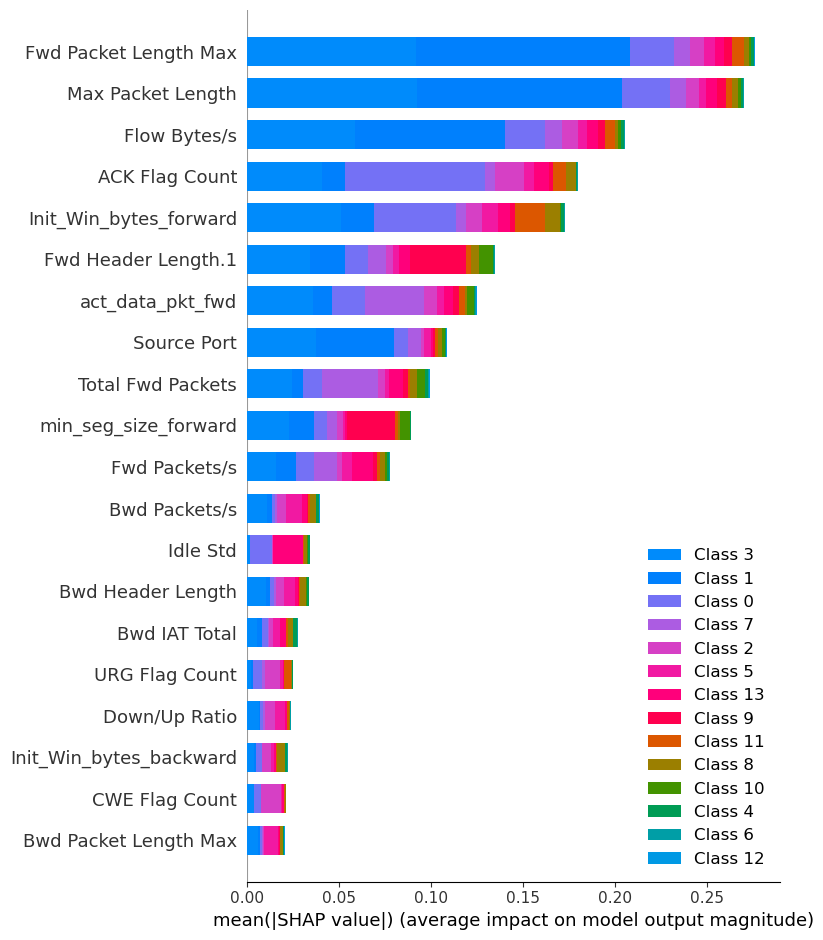

In [22]:
shap.summary_plot(shap_values, ddos_data.drop(columns=['label']), plot_type="bar")

Cluster 0


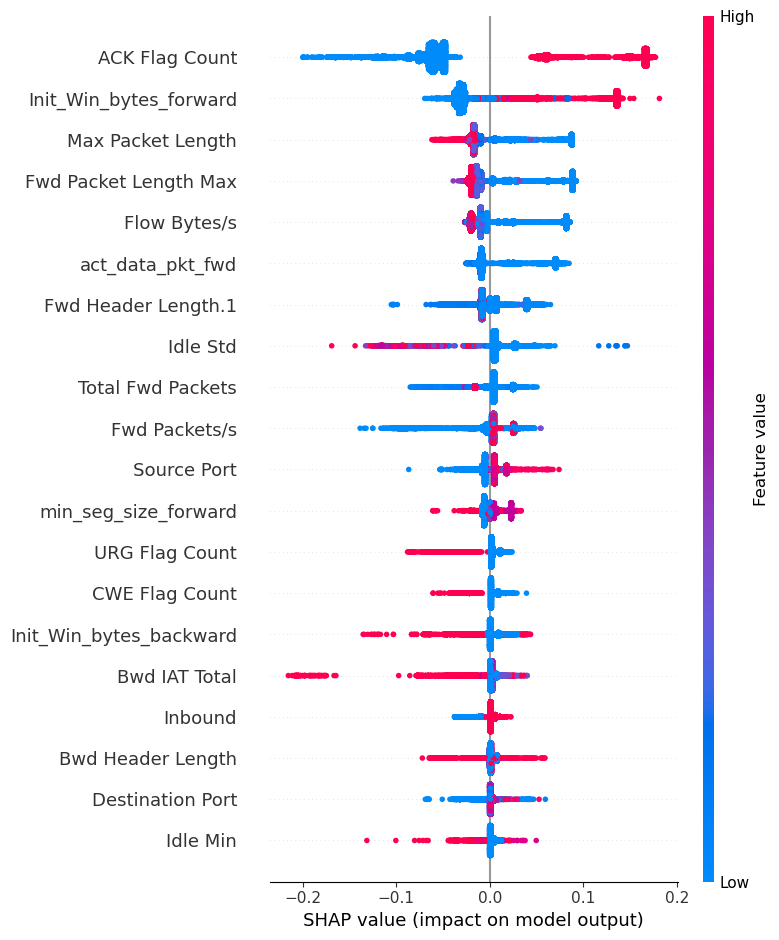

Cluster 1


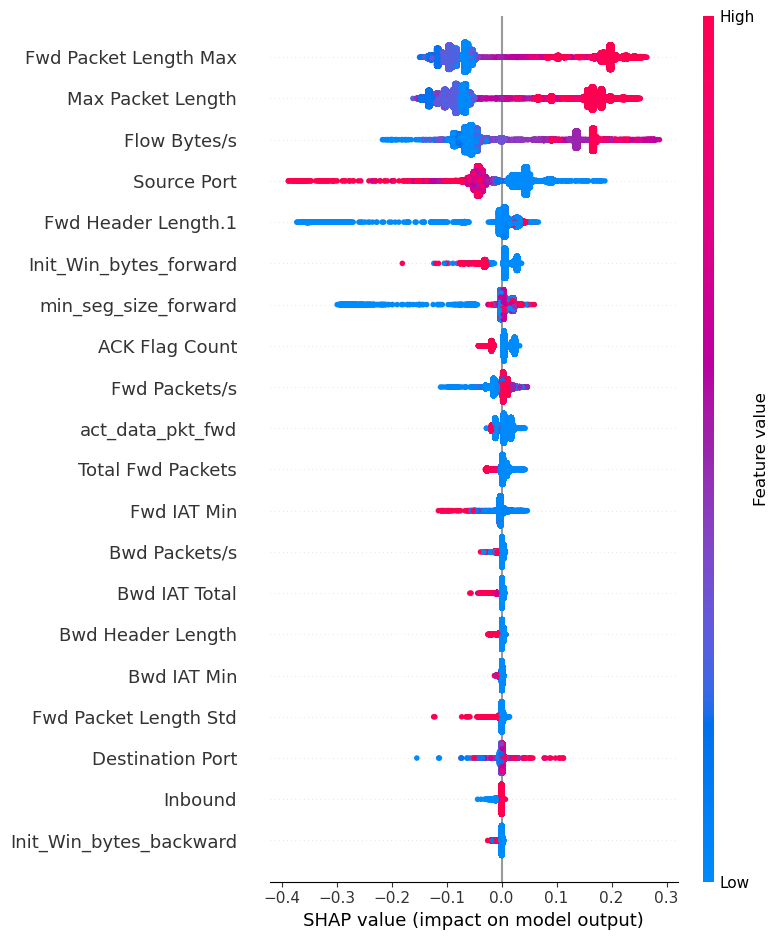

Cluster 2


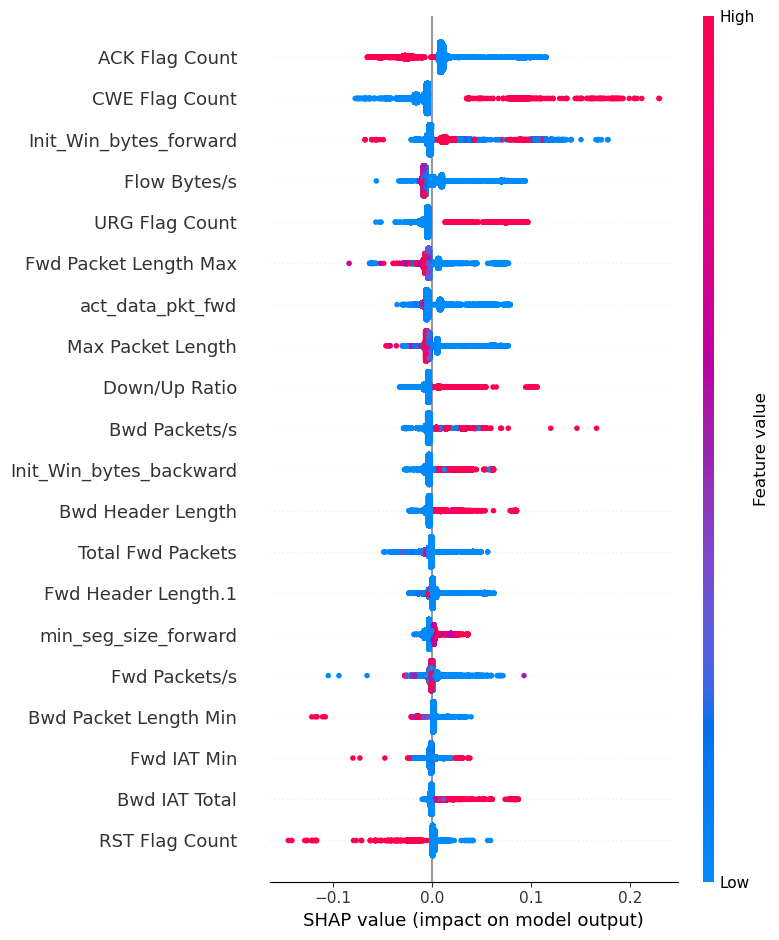

Cluster 3


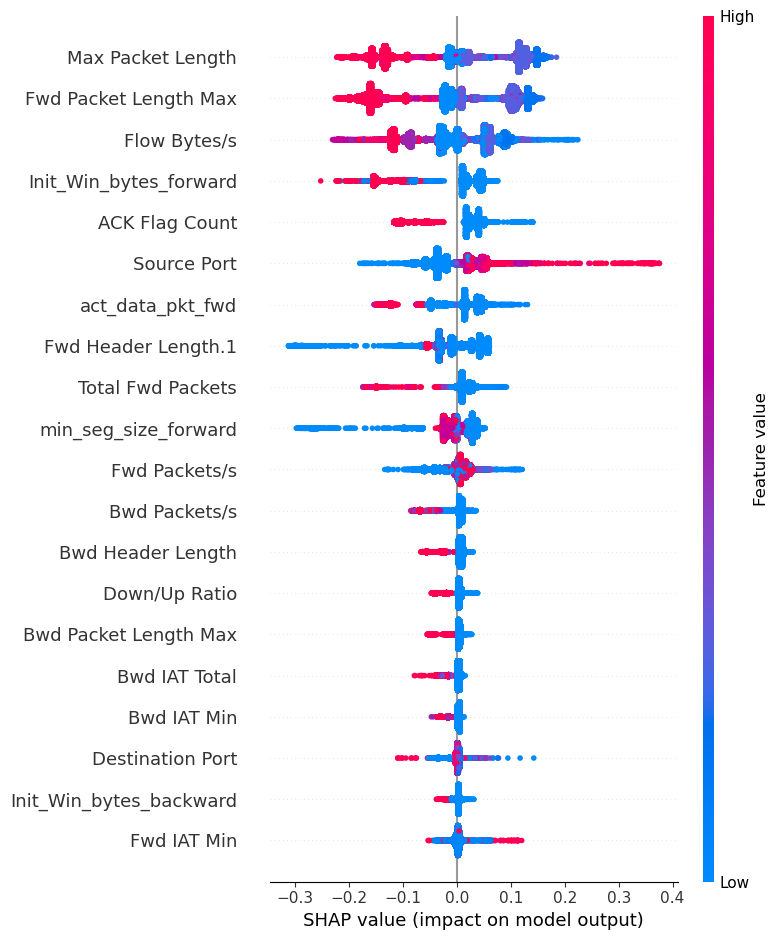

Cluster 4


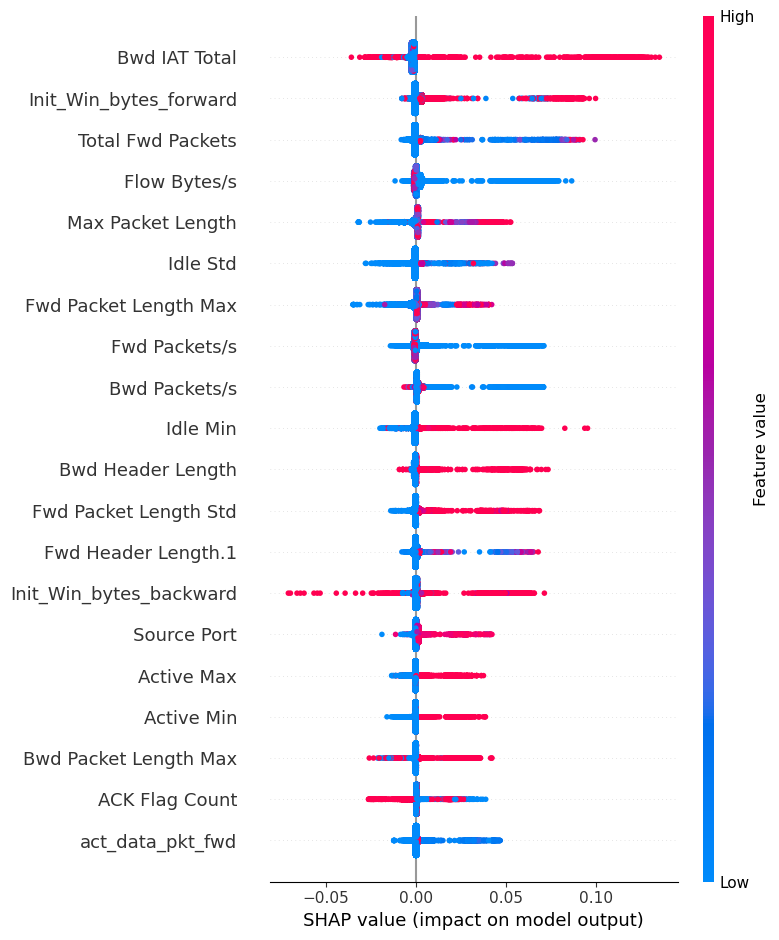

Cluster 5


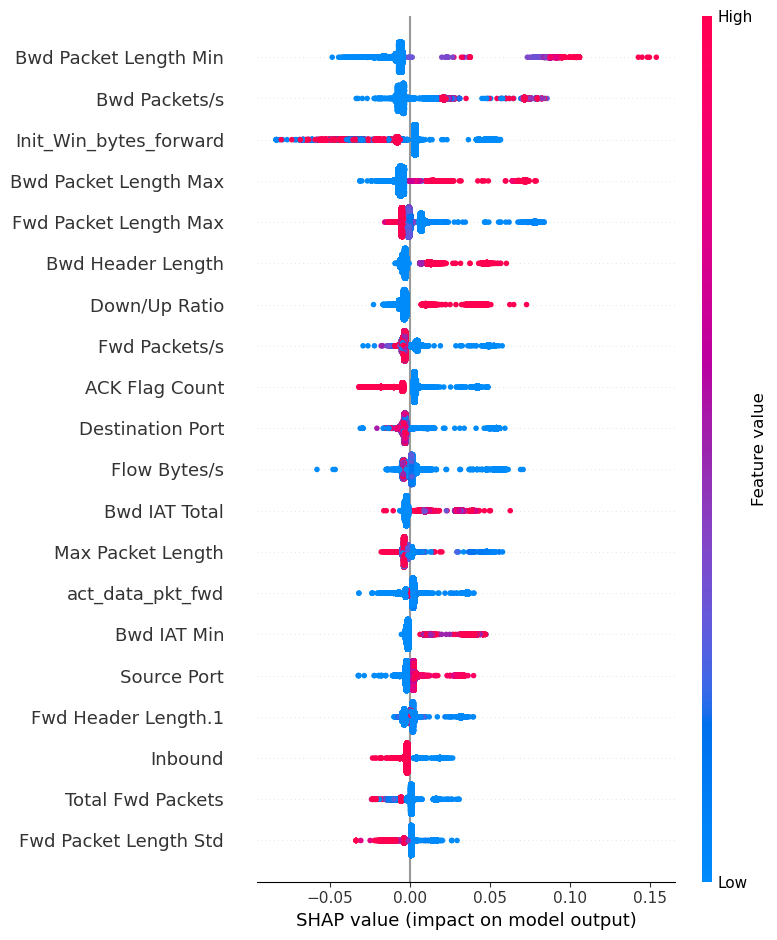

Cluster 6


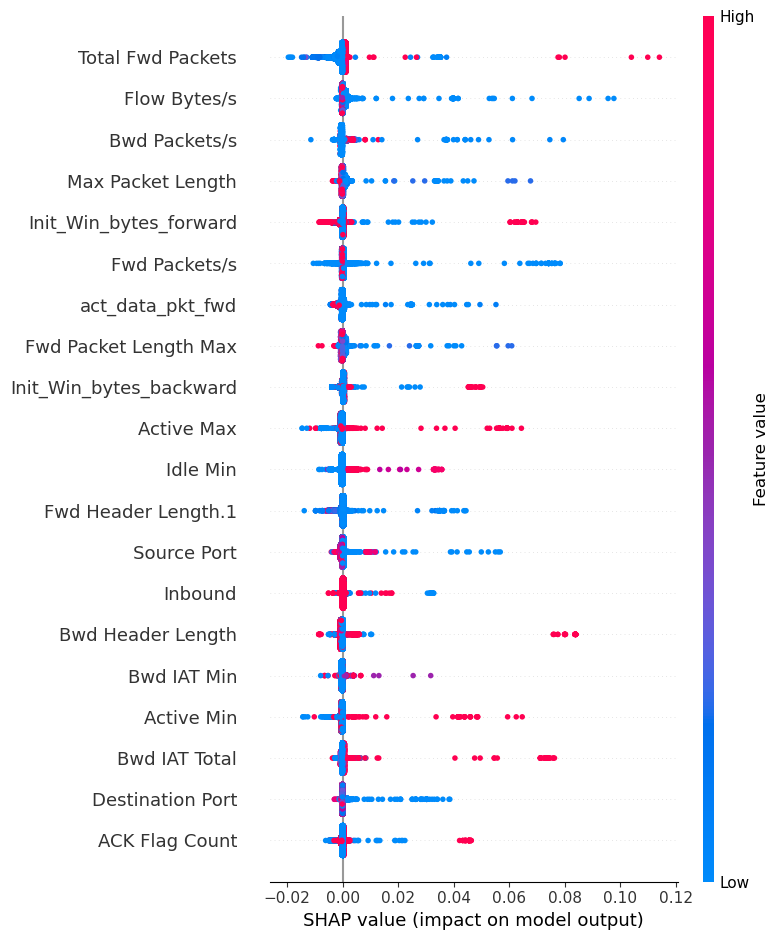

Cluster 7


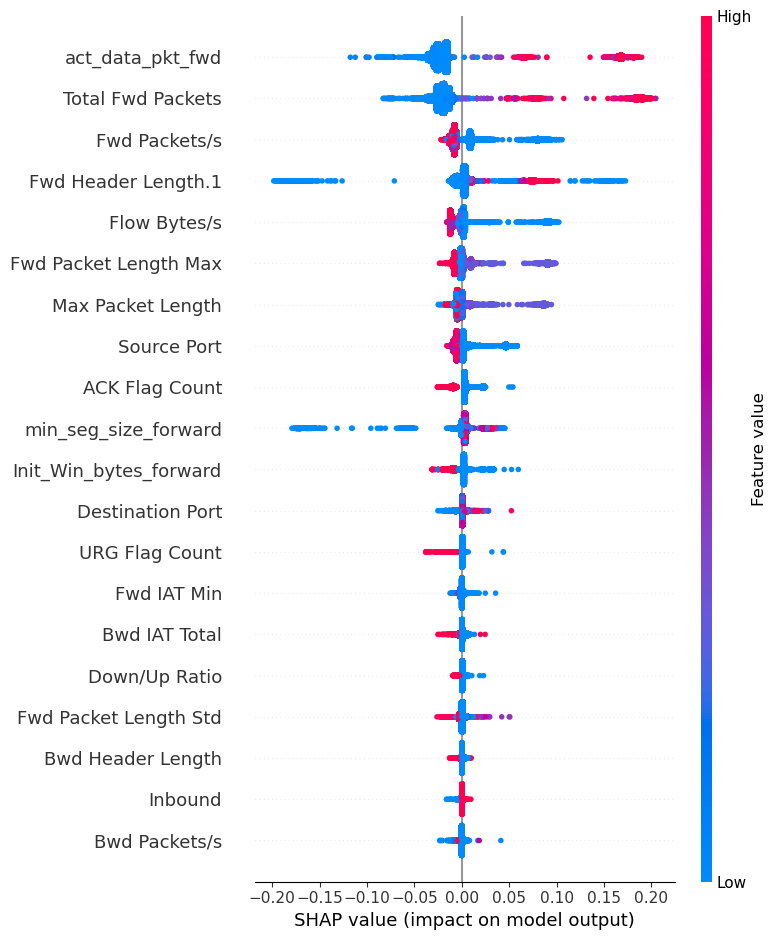

Cluster 8


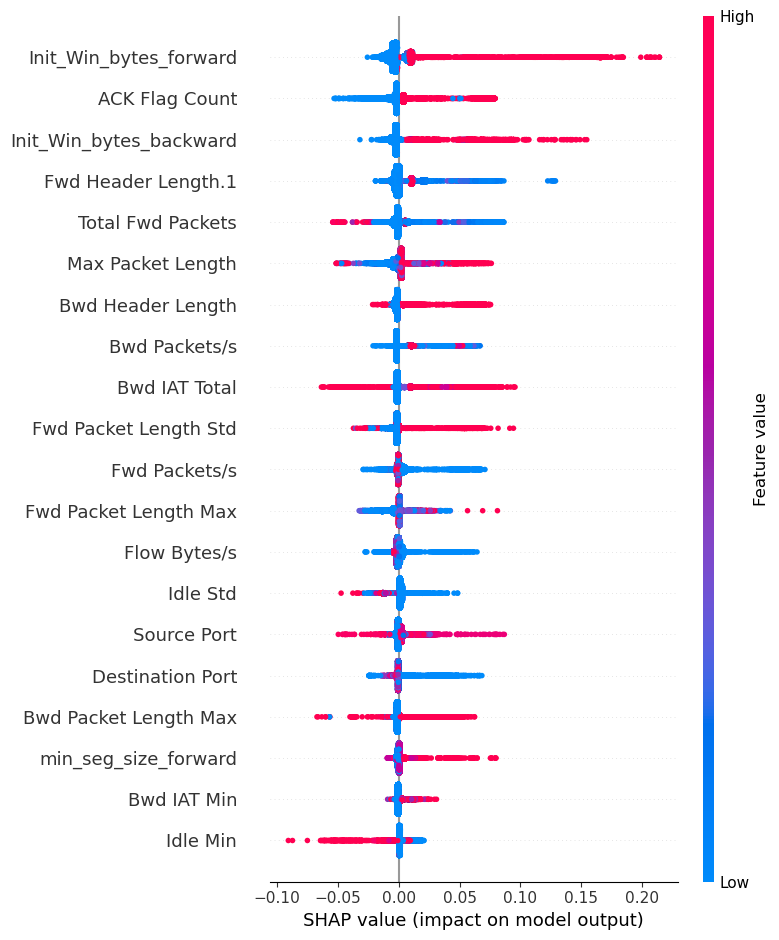

Cluster 9


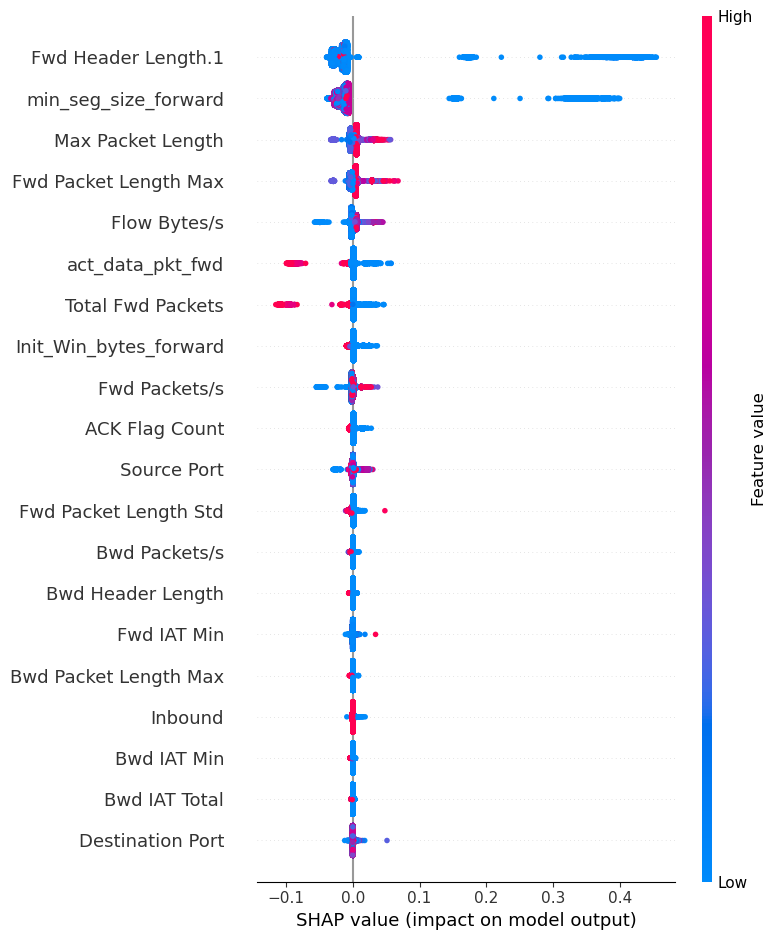

Cluster 10


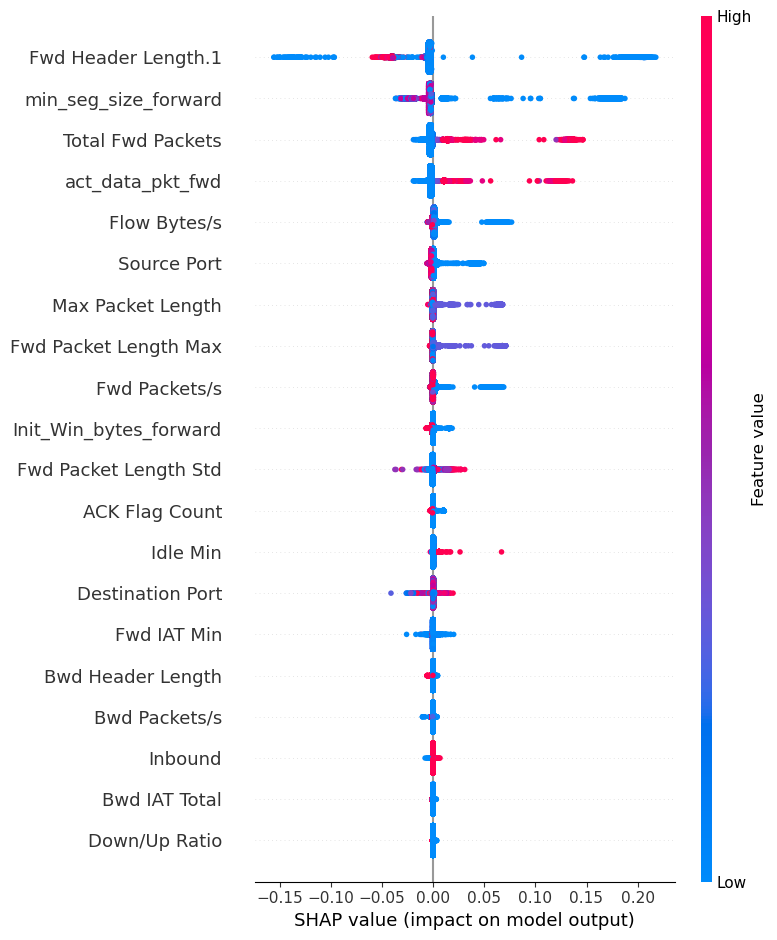

Cluster 11


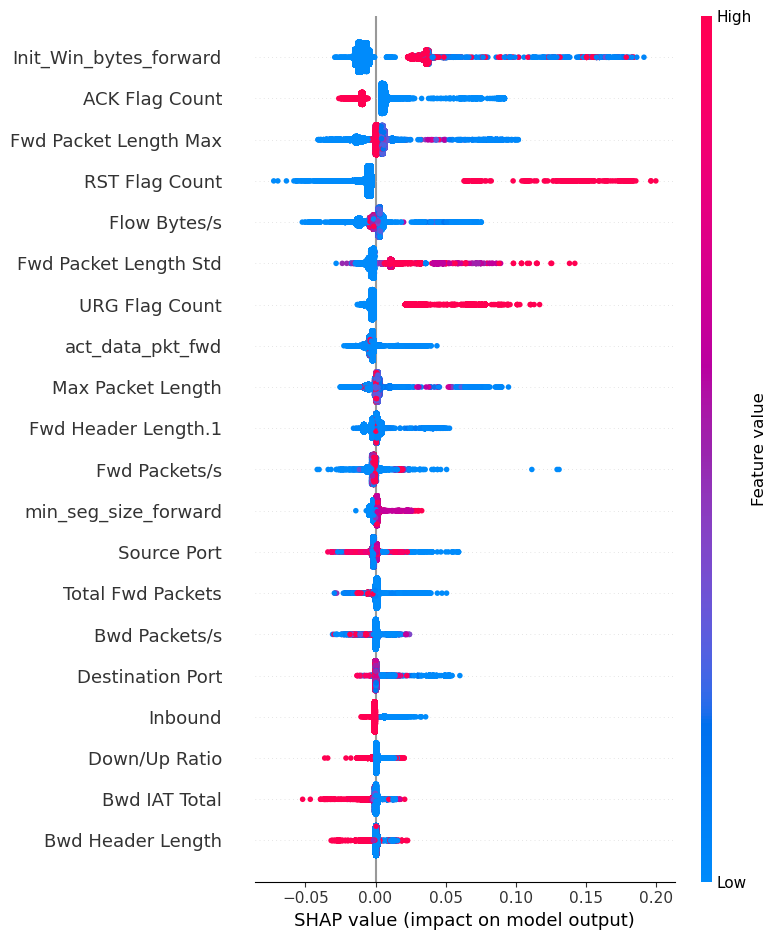

Cluster 12


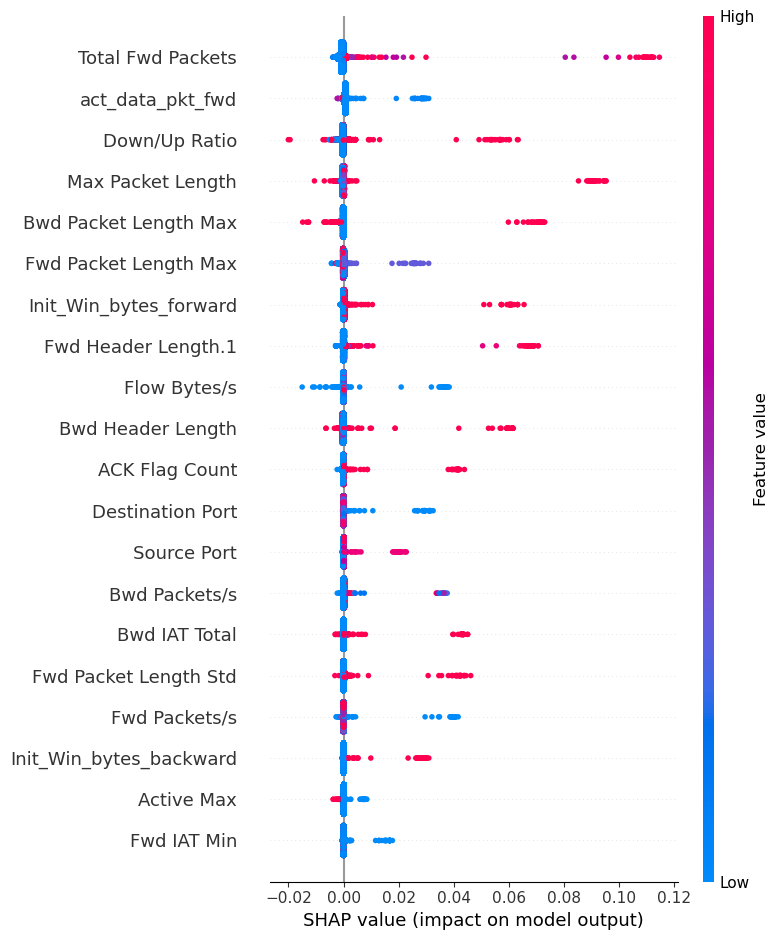

Cluster 13


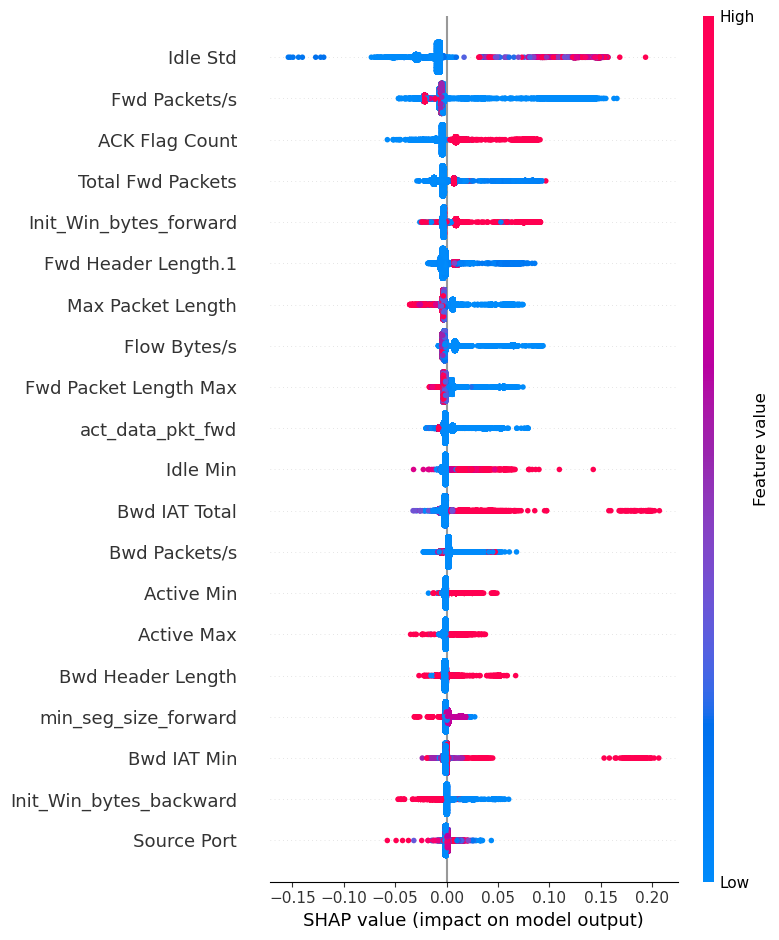

In [23]:
# For each cluster
for i in range(model.n_classes_):
    print(f"Cluster {i}")
    shap.summary_plot(shap_values[i], ddos_data.drop(columns=['label']))